# Waste identification with instance segmentation in TensorFlow

Welcome to the Instance Segmentation Colab! This notebook will take you through the steps of running an "out-of-the-box" Mask RCNN Instance Segmentation model on images.

To finish this task, a proper path for the saved models and a single image needs to be provided. The path to the labels on which the models are trained is in the waste_identification_ml directory inside the Tensorflow Model Garden repository. The label files are inferred automatically for both models.

## Imports and Setup

In [ ]:
!pip install -q tf_keras

In [ ]:
from six.moves.urllib.request import urlopen
from six import BytesIO
from PIL import Image
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib
import logging
import pandas as pd

logging.disable(logging.WARNING)

%matplotlib inline

Run the following cell to import utility functions that will be needed for pre-processing, post-processing and color detection.



To visualize the images with the proper detected boxes and segmentation masks, we will use the TensorFlow Object Detection API. To install it we will clone the repo.



In [ ]:
# Clone the tensorflow models repository.
!git clone --depth 1 https://github.com/tensorflow/models 2>/dev/null

In [ ]:
# Download the script to pull instance segmentation model weights from the TF Model Garden repo.
url = (
    "https://raw.githubusercontent.com/"
    "tensorflow/models/master/"
    "official/projects/waste_identification_ml/"
    "model_inference/download_and_unzip_models.py"
)

!wget -q {url}

In [ ]:
sys.path.append('models/research/')
from object_detection.utils import visualization_utils as viz_utils

In [ ]:
sys.path.append('models/official/projects/waste_identification_ml/model_inference/')
import preprocessing
import postprocessing
import color_and_property_extractor
import labels

## Utilities

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (1, h, w, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


def load_model(model_handle):
    """Loads a TensorFlow SavedModel and returns a function that can be used to make predictions.

    Args:
      model_handle: A path to a TensorFlow SavedModel.

    Returns:
      A function that can be used to make predictions.
    """
    print('loading model...')
    print(model_handle)
    model = tf.saved_model.load(model_handle)
    print('model loaded!')
    detection_fn = model.signatures['serving_default']
    return detection_fn


def perform_detection(model, image):
  """Performs Mask RCNN on an image using the specified model.

  Args:
    model: A function that can be used to make predictions.
    image_np: A NumPy array representing the image to be detected.

  Returns:
    A list of detections.
  """
  detection_fn = model(image)
  detection_fn = {key: value.numpy() for key, value in detection_fn.items()}
  return detection_fn

In [ ]:
# 'material_model' output is both material and its sub type e.g. Plastics_PET.
# 'material_form_model' outputs the form of an object e.g. can, bottle, etc.
MODEL_WEIGHTS = {
    'material_url': (
        'https://storage.googleapis.com/tf_model_garden/vision/'
        'waste_identification_ml/two_model_strategy/material/'
        'material_version_2.zip'
    ),
    'material_form_url': (
        'https://storage.googleapis.com/tf_model_garden/vision/'
        'waste_identification_ml/two_model_strategy/material_form/'
        'material_form_version_2.zip'
    ),
}

ALL_MODELS = {
'material_model' : 'material/saved_model/',
'material_form_model' : 'material_form/saved_model/',
}

LABELS = {
    'material_model': (
        'models/official/projects/waste_identification_ml/pre_processing/'
        'config/data/two_model_strategy_material.csv'
    ),
    'material_form_model': (
        'models/official/projects/waste_identification_ml/pre_processing/'
        'config/data/two_model_strategy_material_form.csv'
    ),
}

# Path to a sample image stored in the repo.
IMAGES_FOR_TEST = {
    'Image1': (
        'models/official/projects/waste_identification_ml/pre_processing/'
        'config/sample_images/image_2.png'
    )
}

## Import pre-trained models.

In [ ]:
# Download the model weights from the Google's repo.
url1 = MODEL_WEIGHTS['material_url']
url2 = MODEL_WEIGHTS['material_form_url']
!python3 download_and_unzip_models.py $url1 $url2

## Load label map data

Label maps correspond index numbers to category names, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [ ]:
# The total number of predicted labels (category_indices) for a combined model = 741.
category_indices, category_index = labels.load_labels(LABELS)

In [ ]:
# Display labels only for 'material' model.
# Total number of labels for 'material' model = 19.
category_indices[0]

['Na',
 'Fiber_Na',
 'Food_Na',
 'Glass_Na',
 'Inorganic-wastes_Na',
 'Metals_Na',
 'Plastics_HDPE',
 'Plastics_LDPE',
 'Plastics_Others-HIPC',
 'Plastics_Others-MLP',
 'Plastics_Others-Tetrapak',
 'Plastics_PET',
 'Plastics_PP',
 'Plastics_PS',
 'Plastics_PVC',
 'Rubber-&-Leather_Na',
 'Textiles_Na',
 'Wood_Na',
 'Yard-trimming_Na']

In [ ]:
# Display labels only for 'material_form' model.
# Total number of labels for 'material form' model = 39.
category_indices[1]

['Na',
 'Bag',
 'Battery',
 'Blister-pack',
 'Book-&-magazine',
 'Bottle',
 'Box',
 'Brush',
 'Bulb',
 'Can',
 'Cards',
 'Carton',
 'Cassette-&-tape',
 'Clamshell',
 'Clothes',
 'Container',
 'Cosmetic',
 'Cup-&-glass',
 'Cutlery',
 'Electronic-devices',
 'Flexibles',
 'Foil',
 'Foot-wear',
 'Hangers',
 'Jug-&-Jar',
 'Lid',
 'Mirror',
 'Office-Stationary',
 'Paper-Products-Others',
 'Paper-Products-Others-Cardboard',
 'Paper-Products-Others-Newspaper',
 'Paper-Products-Others-Whitepaper',
 'Pipe',
 'Sachets-&-Pouch',
 'Scissor',
 'Tangler',
 'Toys',
 'Tray',
 'Tube']

## Load pre-trained weights for both models.

In [ ]:
# Loading both models.
detection_fns = [load_model(model_path) for model_path in ALL_MODELS.values()]

loading model...
material/two_model_material_1_saved/saved_model/
model loaded!
loading model...
material_form/two_model_material_form_1_saved/saved_model/
model loaded!


## Loading an image

Let's try the model on a simple image. Here are some simple things to try out if you are curious:



*   Try running inference on your own images, just upload them to colab and load the same way it's done in the cell below.
*   Modify some of the input images and see if detection still works. Some simple things to try out here include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).

Be careful: when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.

In [ ]:
selected_image = 'Image1'
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if (flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if (convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

print('min:', np.min(image_np[0]), 'max:', np.max(image_np[0]))
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

min: 0 max: 255


## Pre-processing an image

In [ ]:
# Get an input size of images from one of the Instance Segmentation model.
height = detection_fns[0].structured_input_signature[1]['inputs'].shape[1]
width = detection_fns[0].structured_input_signature[1]['inputs'].shape[2]
input_size = (height, width)
print(input_size)

(512, 1024)


In [ ]:
image_np_cp = tf.image.resize(image_np[0], input_size, method=tf.image.ResizeMethod.AREA)
image_np_cp = tf.cast(image_np_cp, tf.uint8)
image_np = preprocessing.normalize_image(image_np_cp)
image_np = tf.expand_dims(image_np, axis=0)
image_np.get_shape()

TensorShape([1, 512, 1024, 3])

In [ ]:
# Display pre-processed image.
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## Doing the inference

In [ ]:
# Running inference with bith the models.
results = list(map(lambda model: perform_detection(model, image_np), detection_fns))

## Merge results, extract properties and detect colors

In [ ]:
SCORE_THRESH = 0.8

no_detections_in_first = results[0]['num_detections'][0]
no_detections_in_second = results[1]['num_detections'][0]

if no_detections_in_first !=0 and no_detections_in_second != 0:
  # Reframe the masks from the output of the model to its original size.
  results = [postprocessing.reframing_masks(detection, height, width) for detection in results]

  # Required to loop over the first max_detection values from both model outputs.
  max_detection = max(no_detections_in_first, no_detections_in_second)

  # This threshold will be used to eliminate all the detected objects whose area
  # is greater than the 'area_threshold'.
  area_threshold = 0.3 * np.product(image_np_cp.shape[:2])

  # Align similar masks from both the model outputs and merge all the properties
  # into a single mask. Function will only compare first 'max_detection' objects
  # All the objects which have less than 'SCORE_THRESH' probability will be
  # eliminated. All objects whose area is more than 'area_threshold' will be
  # eliminated. 'category_dict' and 'category_index' are used to find the label
  # from the combinations of labels from both individual models. The output
  # should include masks appearing in either of the models if they qualify the
  # criteria.
  final_result = postprocessing.find_similar_masks(
      results[0],
      results[1],
      max_detection,
      SCORE_THRESH,
      category_indices,
      category_index,
      area_threshold
  )

  # Convert normalized bounding box cocrdinates to their original format.
  transformed_boxes = []
  for bb in final_result['detection_boxes'][0]:
      YMIN = int(bb[0]*height)
      XMIN = int(bb[1]*width)
      YMAX = int(bb[2]*height)
      XMAX = int(bb[3]*width)
      transformed_boxes.append([YMIN, XMIN, YMAX, XMAX])

  # Filtering duplicate bounding boxes.
  filtered_boxes, index_to_delete = (
    postprocessing.filter_bounding_boxes(transformed_boxes))

  # Removing the corresponding values from all keys of a dictionary which
  # corresponds to the duplicate bounding boxes.
  final_result['num_detections'][0] -= len(index_to_delete)
  final_result['detection_classes'] = np.delete(
      final_result['detection_classes'], index_to_delete)
  final_result['detection_scores'] = np.delete(
      final_result['detection_scores'], index_to_delete, axis=1)
  final_result['detection_boxes'] = np.delete(
      final_result['detection_boxes'], index_to_delete, axis=1)
  final_result['detection_classes_names'] = np.delete(
      final_result['detection_classes_names'], index_to_delete)
  final_result['detection_masks_reframed'] = np.delete(
      final_result['detection_masks_reframed'], index_to_delete, axis=0)

  if final_result['num_detections'][0]:

    # Calculate properties of each object for object tracking purpose.
    dfs, cropped_masks = (
        color_and_property_extractor.extract_properties_and_object_masks(
            final_result, height, width, image_np_cp))
    features = pd.concat(dfs, ignore_index=True)
    features['image_name'] = selected_image
    features.rename(columns={
        'centroid-0':'y',
        'centroid-1':'x',
        'bbox-0':'bbox_0',
        'bbox-1':'bbox_1',
        'bbox-2':'bbox_2',
        'bbox-3':'bbox_3'
    }, inplace=True)

    # Find color of each object.
    dominant_colors = [*map(color_and_property_extractor.find_dominant_color, cropped_masks)]
    color_names = [*map(color_and_property_extractor.get_color_name, dominant_colors)]
    features['color'] = color_names

In [ ]:
# Showing all properties of 1st object in an image
features.iloc[0]

area                        6455
bbox_0                       327
bbox_1                       342
bbox_2                       481
bbox_3                       490
convex_area                 6899
bbox_area                  22792
major_axis_length     215.927556
minor_axis_length       39.32658
eccentricity            0.983275
y                     402.730132
x                     415.564833
image_name                Image1
color                saddlebrown
Name: 0, dtype: object

## Visualization of masks

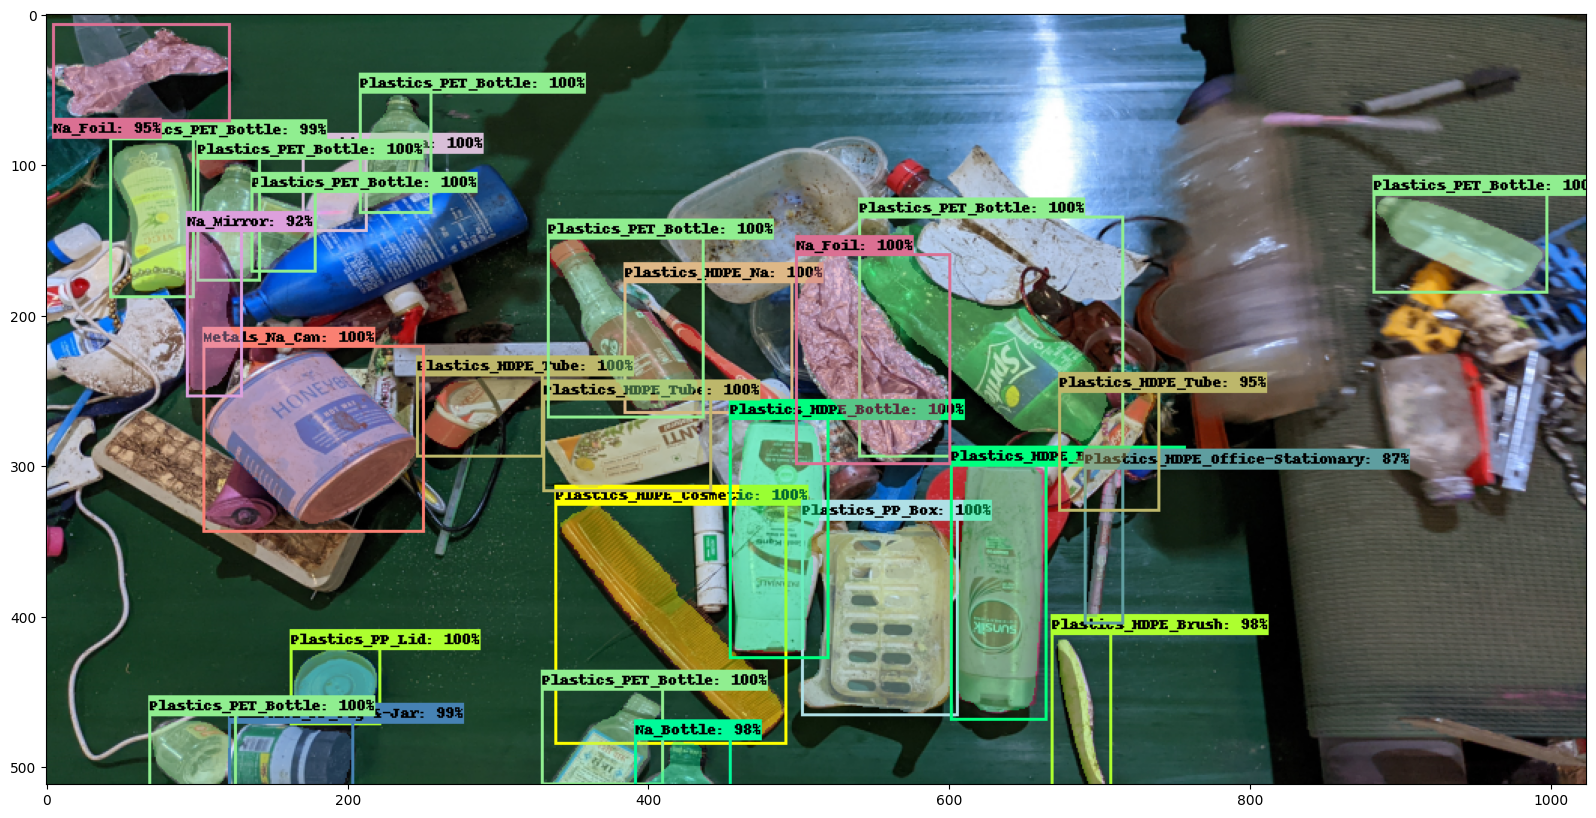

In [ ]:
%matplotlib inline
image_new = image_np_cp.numpy().copy()

if 'detection_masks_reframed' in final_result:
  final_result['detection_masks_reframed'] = final_result['detection_masks_reframed'].astype(np.uint8)

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_new,
      final_result['detection_boxes'][0],
      (final_result['detection_classes'] + 0).astype(int),
      final_result['detection_scores'][0],
      category_index=category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=0.6,
      agnostic_mode=False,
      instance_masks=final_result.get('detection_masks_reframed', None),
      line_thickness=2)

plt.figure(figsize=(20,10))
plt.imshow(image_new)
plt.show()

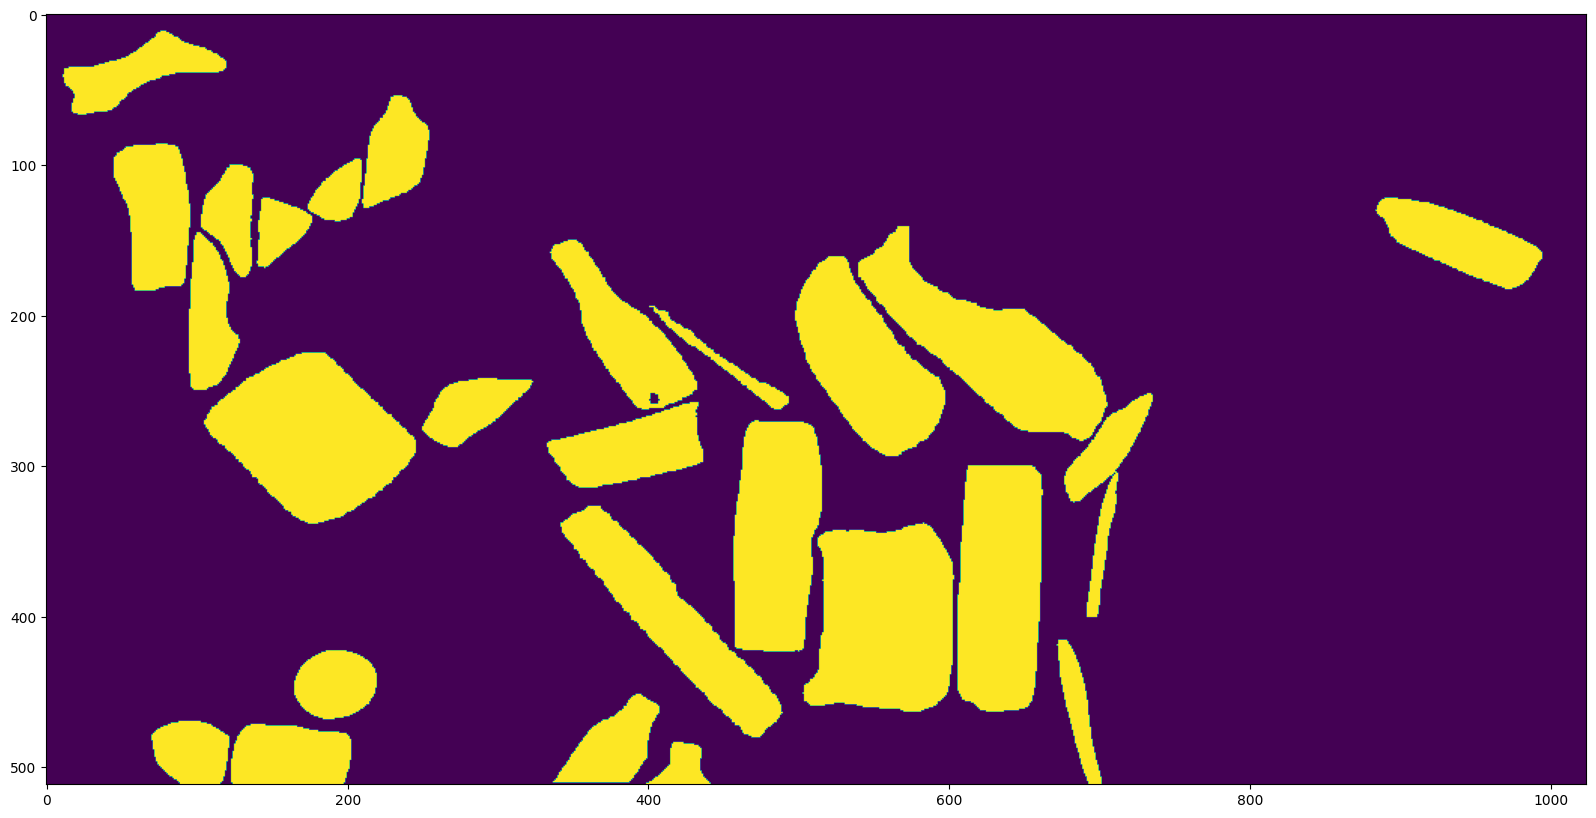

In [ ]:
# Visualize binary masks.
mask = np.zeros_like(final_result['detection_masks_reframed'][0])
for i in final_result['detection_masks_reframed']:
  mask += i

plt.figure(figsize=(20,10))
plt.imshow(mask)
plt.show()